In [1]:
import uproot
import awkward as ak
import numpy as np
import os
import math
import torch_geometric
import torch
from torch_geometric.data import Data
import os.path as osp

In [2]:
#filein='/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v38/cmssw/data/CLUE_clusters.root' ## data
filein='/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v38/cmssw/sim_proton_v46_patchMIP/CLUE_clusters.root' ##sim
fin = uproot.open(filein)["clusters"]

In [3]:
#fin.keys()

In [4]:
evinfo = fin.arrays([i  for i in fin.keys() if 'rechit' not in i  and 'clus' not in i])
rhita = fin.arrays([i for i in fin.keys() if 'rechit' in i])
clus2da = fin.arrays([i for i in fin.keys() if 'clus2D' in i])
clus3da = fin.arrays([i for i in fin.keys() if 'clus3D' in i])

In [7]:
from tqdm import tqdm as tqdm
lst = []
""" Ratios of main trackster energy of true beam energy"""
lst21 = []
""" Ratios of second-to-first trackster energies (sorting tracksters by descending energies)"""
skipevt = 0
for evt in tqdm(range(len(evinfo["trueBeamEnergy"]))):
    evinfo_ev = evinfo[evt]
    rhev = rhita[evt]
    cl2dev = clus2da[evt]
    cl3dev = clus3da[evt]
    
    trueEn = evinfo_ev["trueBeamEnergy"]
    idxsrt = np.argsort(cl3dev['clus3D_energy'])
    if len(idxsrt) < 1:
        skipevt += 1
        continue
    
    
    if len(idxsrt) > 1: # ???? why not >=1
        idxmax = idxsrt[-1]
        """ index of largest trackster """
        enrat = cl3dev['clus3D_energy'][idxmax]/trueEn
        enrat2 = cl3dev['clus3D_energy'][idxsrt[-2]] / cl3dev['clus3D_energy'][idxsrt[-1]]
        
        lst.append(enrat)
        lst21.append(enrat2)
        
        if enrat > 0.7 and enrat2 < 0.011:    
            # select all rechits member of the largest trackster
            rhs = np.array([ rhev["rechits_x"][ak.flatten(cl2dev["clus2D_idxs"][cl3dev["clus3D_idxs"][idxmax]])],
                            rhev["rechits_y"][ak.flatten(cl2dev["clus2D_idxs"][cl3dev["clus3D_idxs"][idxmax]])],
                            #rhev["rechits_z"][ak.flatten(cl2dev["clus2D_idxs"][cl3dev["clus3D_idxs"][idxmax]])],
                            rhev["rechits_layer"][ak.flatten(cl2dev["clus2D_idxs"][cl3dev["clus3D_idxs"][idxmax]])],
                            rhev["rechits_energy"][ak.flatten(cl2dev["clus2D_idxs"][cl3dev["clus3D_idxs"][idxmax]])]
                           ])
            # select all LC members of the largest trackster
            cl2ds = np.array([ cl2dev["clus2D_x"][cl3dev["clus3D_idxs"][idxmax]],
                            cl2dev["clus2D_y"][cl3dev["clus3D_idxs"][idxmax]],
                            #cl2dev["clus2D_z"][cl3dev["clus3D_idxs"][idxmax]],
                            cl2dev["clus2D_layer"][cl3dev["clus3D_idxs"][idxmax]],
                            cl2dev["clus2D_energy"][cl3dev["clus3D_idxs"][idxmax]]
                           ])
            
            rhs_l = rhev["rechits_layer"][ak.flatten(cl2dev["clus2D_idxs"][cl3dev["clus3D_idxs"][idxmax]])]
            ## either z or layer
            # 28-length with sum of rechits energies on each layer
            rhls = np.array([np.sum(rhs.T[:,3][rhs_l == i + 1]) if (np.sum(rhs.T[:,3][rhs_l == i + 1]) > 0) else 0. for i in range(28)  ])
            
            '''print(np.sum(rhls),np.sum(rhs.T[:,3]))
            print(len(rhls))
            
            print("rhs",rhs.shape)
            print(cl2ds.shape)'''

                
            processed_dir = "/grid_mnt/data__data.polcms/cms/sghosh/TESTBEAMDATA/TBDGRAPHS/test31052023_l"    
            
            #processed_dir = "/home/llr/cms/sghosh/TESTBEAM/Regression"
            
            # 
            torch.save(Data(rh = torch.tensor(rhs.T, dtype=torch.float32),
                        cl2d = torch.tensor(cl2ds.T, dtype=torch.float32),
                        rhl = torch.tensor(rhls, dtype=torch.float32),
                        truen = torch.tensor(trueEn,dtype=torch.float32)),
            osp.join(processed_dir, 'tbd_{}.pt'.format(evt)))
            #          ))
            
            
            
            
            
            
            
            
            
            '''
            fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12),dpi=80)


            ax0.scatter(rhita["rechits_x"][evt],rhita["rechits_z"][evt],s=rhita["rechits_energy"][evt]*30,alpha=0.4)
            ax0.set_xlabel('X (cms)')
            ax0.set_ylabel('Z (cms)')
            ax1.scatter(rhita["rechits_y"][evt],rhita["rechits_z"][evt],s=rhita["rechits_energy"][evt]*30,alpha=0.4)
            ax1.set_xlabel('Y (cms)')
            ax1.set_ylabel('Z (cms)')

            ax2.scatter(rhita["rechits_x"][evt],rhita["rechits_y"][evt],s=rhita["rechits_energy"][evt]*30,alpha=0.4)
            ax2.set_xlabel('X (cms)')
            ax2.set_ylabel('Y (cms)')

            #plt.show()


            #fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12),dpi=80)


            ax0.scatter(clus3da["clus3D_x"][evt],clus3da["clus3D_z"][evt],s=clus3da["clus3D_energy"][evt]*30,alpha=0.4,c='r')
            ax0.set_xlabel('X (cms)')
            ax0.set_ylabel('Z (cms)')
            ax1.scatter(clus3da["clus3D_y"][evt],clus3da["clus3D_z"][evt],s=clus3da["clus3D_energy"][evt]*30,alpha=0.4,c='r')
            ax1.set_xlabel('Y (cms)')
            ax1.set_ylabel('Z (cms)')

            ax2.scatter(clus3da["clus3D_x"][evt],clus3da["clus3D_y"][evt],s=clus3da["clus3D_energy"][evt]*30,alpha=0.4,c='r')
            ax2.set_xlabel('X (cms)')
            ax2.set_ylabel('Y (cms)')

            plt.show()
            
            
            fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12),dpi=80)


            ax0.scatter(rhs.T[:,0],rhs.T[:,2],s=rhs.T[:,4]*30,alpha=0.4)
            ax0.set_xlabel('X (cms)')
            ax0.set_ylabel('Z (cms)')
            ax1.scatter(rhs.T[:,1],rhs.T[:,2],s=rhs.T[:,4]*30,alpha=0.4)
            ax1.set_xlabel('Y (cms)')
            ax1.set_ylabel('Z (cms)')

            ax2.scatter(rhs.T[:,0],rhs.T[:,1],s=rhs.T[:,4]*30,alpha=0.4)
            ax2.set_xlabel('X (cms)')
            ax2.set_ylabel('Y (cms)')

            #plt.show()


            #fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12),dpi=80)
            
            ax0.scatter(cl2ds.T[:,0],cl2ds.T[:,2],s=cl2ds.T[:,4]*30,alpha=0.4,c='g')
            ax0.set_xlabel('X (cms)')
            ax0.set_ylabel('Z (cms)')
            ax1.scatter(cl2ds.T[:,1],cl2ds.T[:,2],s=cl2ds.T[:,4]*30,alpha=0.4,c='g')
            ax1.set_xlabel('Y (cms)')
            ax1.set_ylabel('Z (cms)')

            ax2.scatter(cl2ds.T[:,0],cl2ds.T[:,1],s=cl2ds.T[:,4]*30,alpha=0.4,c='g')
            ax2.set_xlabel('X (cms)')
            ax2.set_ylabel('Y (cms)')
            
            

            ax0.scatter(cl3dev["clus3D_x"],cl3dev["clus3D_z"],s=cl3dev["clus3D_energy"]*30,alpha=0.4,c='r')
            ax0.set_xlabel('X (cms)')
            ax0.set_ylabel('Z (cms)')
            ax1.scatter(cl3dev["clus3D_y"],cl3dev["clus3D_z"],s=cl3dev["clus3D_energy"]*30,alpha=0.4,c='r')
            ax1.set_xlabel('Y (cms)')
            ax1.set_ylabel('Z (cms)')

            ax2.scatter(cl3dev["clus3D_x"],cl3dev["clus3D_y"],s=cl3dev["clus3D_energy"]*30,alpha=0.4,c='r')
            ax2.set_xlabel('X (cms)')
            ax2.set_ylabel('Y (cms)')

            plt.show()'''
            
            
            #print("processed one event")
            #break
    
    

  0%|          | 1/369929 [00:46<4782:30:20, 46.54s/it]

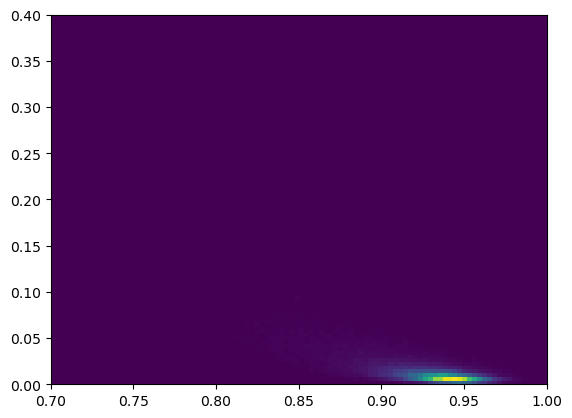

In [21]:
import matplotlib.pyplot as plt
plt.hist2d(lst,lst21,bins=[100,100],range=[[0.7,1.],[0,0.4]])
plt.show()
#clus3da['clus3D_energy'][:,]
#np.unique(np.array(lst),return_counts=True)
#len(evinfo["trueBeamEnergy"])


In [22]:
evinfo["DWC_passes_cuts"]

<Array [True, True, True, True, ..., True, True, True] type='369929 * bool'>

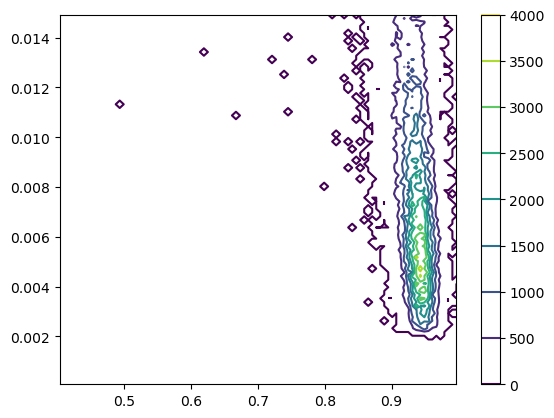

In [23]:
fig = plt.figure()
h, xedges, yedges = np.histogram2d(lst,lst21,bins=[100,100],range=[[0.4,1.],[0,0.015]],density=True)
xbins = xedges[:-1] + (xedges[1] - xedges[0]) / 2
ybins = yedges[:-1] + (yedges[1] - yedges[0]) / 2

h = h.T
CS = plt.contour(xbins, ybins, h)
#plt.scatter(lst,lst21)
plt.colorbar()
plt.show()

In [ ]:
loadd = torch.load("tbd_5.pt")
loadd.keys
loadd["rhl"]